In [1]:
import gym
from matplotlib import pyplot as plt
import numpy as np
from gym.envs.toy_text.taxi import *
import random
from scipy.signal import savgol_filter

import warnings
warnings.filterwarnings("ignore")

In [2]:
env = gym.make("Taxi-v3")
env_decode = TaxiEnv()

In [3]:
def policy(q_sa, eps):

    if np.random.rand() < eps:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(q_sa)
    
    return action

In [4]:
all_together = []
# decay_multiplier = 0.9
episodes = 1000
discount_factor = 0.9


for planning_steps in [5, 25, 50, 75, 100]:

    Q_SA = {}
    for possible_states in range(500):
        Q_SA[possible_states] = {}
        for possible_actions in range(6):
            Q_SA[possible_states][possible_actions] = 0.25

    Model = {}
    for possible_states in range(500):
        Model[possible_states] = {}
        for possible_actions in range(6):
            Model[possible_states][possible_actions] = []
            
    exploration = 0.25
    learning_rate = 0.75

    all_rewards = []

    for ep in range(episodes):

        S = []
        A = []
        R = []

        obs = env.reset()
        S.append(obs)

        done = False

        while not done:
        
            action = policy([Q_SA[S[-1]][i] for i in range(6)], exploration)

            A.append(action)

            obs, reward, done, info = env.step(action)

            R.append(reward)
            S.append(obs)

            Q_SA[S[-2]][action] += learning_rate * (reward + (discount_factor * np.max([Q_SA[S[-1]][i] for i in range(6)])) - Q_SA[S[-2]][action])

            Model[S[-2]][action] = [R[-1], S[-1]]


            for n in range(planning_steps):
                rand_idx = random.randint(0, len(S) - 2)
                state = S[rand_idx]
                action = A[rand_idx]
                [r, s_d] = Model[state][action]

                Q_SA[state][action] += learning_rate * (r + (discount_factor * np.max([Q_SA[s_d][i] for i in range(6)])) - Q_SA[state][action])
                        
        all_rewards.append(R)

        # learning_rate = learning_rate * decay_multiplier
        # exploration = exploration * decay_multiplier
    
    all_together.append(all_rewards)

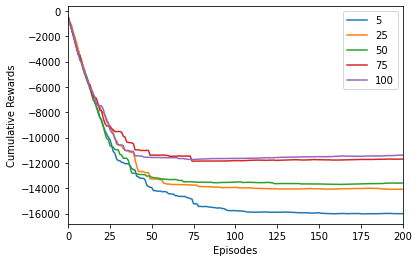

In [5]:
for rewards in all_together:
    running_sum = 0
    cumulative_sum = []
    for r in rewards:
        running_sum += np.sum(r)
        cumulative_sum.append(running_sum)
    plt.plot(cumulative_sum)

plt.legend(['5', '25', '50', '75', '100'])
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.xlim([0, 200])

plt.show()

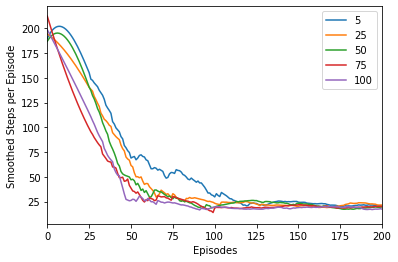

In [6]:
def smooth(this):
    return savgol_filter(this, 51, 3)

for rewards in all_together:
    plt.plot(smooth([len(r) for r in rewards]))

plt.legend(['5', '25', '50', '75', '100'])
plt.xlabel('Episodes')
plt.ylabel('Smoothed Steps per Episode')
plt.xlim([0, 200])

plt.show()